/var/folders/2x/5hkn8q8n76b7blr_q1kgdtj40000gn/T/ipykernel_88771/967829956.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


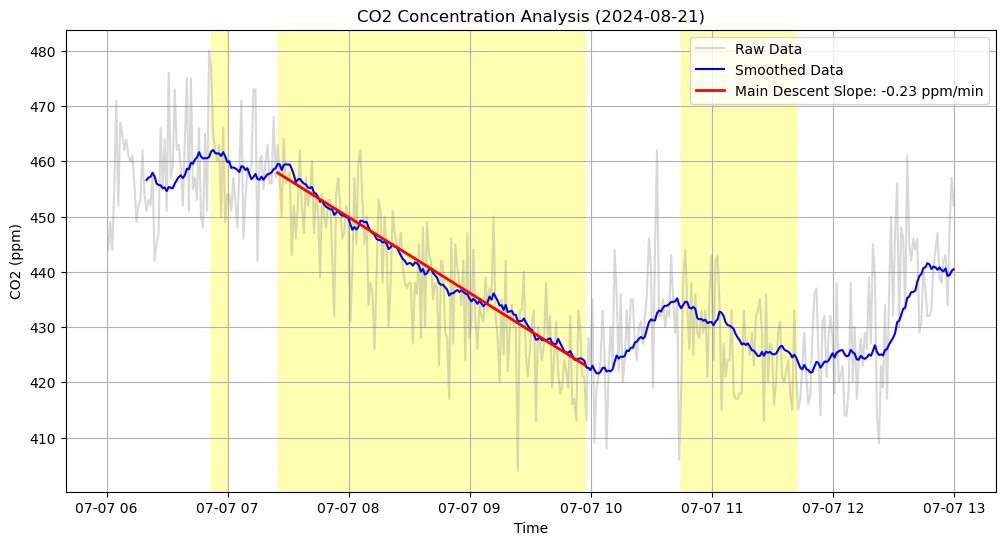

Main descent period: 07:24 - 09:56
Overall slope: -0.23 ppm/min


In [7]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Database connection
conn = psycopg2.connect(
    host='techsense.panspace.me',
    database='plantgrowth',
    user='WTLab',
    password='WTLab502'
)

# Query data
query = """
SELECT timestamp, co2
FROM sensor_data
WHERE location = 'indoor'
    AND timestamp::date = '2024-07-07'
    AND EXTRACT(HOUR FROM timestamp) BETWEEN 6 AND 12
ORDER BY timestamp;
"""

# Read data
df = pd.read_sql(query, conn)
df.set_index('timestamp', inplace=True)

# Calculate rolling mean to smooth the data
df['co2_smooth'] = df['co2'].rolling(window=20).mean()

# Calculate rolling slope over 20-minute windows
window_minutes = 10
slopes = []
timestamps = []

for i in range(len(df) - window_minutes):
    window = df['co2_smooth'].iloc[i:i + window_minutes]
    slope, _, _, _, _ = stats.linregress(range(len(window)), window)
    slopes.append(slope)
    timestamps.append(df.index[i])

df['slope'] = pd.Series(slopes, index=timestamps)

# Find continuous descent period
# Consider it a descent if slope is negative for at least 5 minutes
descent_threshold = -0.2  # adjust this value based on your data
min_descent_duration = pd.Timedelta(minutes=5)

is_descending = df['slope'] < descent_threshold
descent_periods = []
current_start = None

for idx, is_desc in is_descending.items():
    if is_desc and current_start is None:
        current_start = idx
    elif not is_desc and current_start is not None:
        if idx - current_start >= min_descent_duration:
            descent_periods.append((current_start, idx))
        current_start = None

# Merge close descent periods
merged_periods = []
if descent_periods:
    current_start, current_end = descent_periods[0]

    for start, end in descent_periods[1:]:
        if start - current_end <= pd.Timedelta(minutes=15):  # if periods are within 10 minutes
            current_end = end
        else:
            merged_periods.append((current_start, current_end))
            current_start, current_end = start, end

    merged_periods.append((current_start, current_end))

# Calculate slope for the main descent period
if merged_periods:
    main_period = max(merged_periods, key=lambda x: x[1] - x[0])
    main_start, main_end = main_period

    y = df['co2_smooth'].loc[main_start:main_end]
    x = np.arange(len(y))
    main_slope, intercept, r_value, _, _ = stats.linregress(x, y)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['co2'], 'gray', alpha=0.3, label='Raw Data')
    plt.plot(df.index, df['co2_smooth'], 'b', label='Smoothed Data')

    # Plot all descent periods
    for start, end in merged_periods:
        plt.axvspan(start, end, color='yellow', alpha=0.3)

    # Plot regression line for main period
    plt.plot(df.loc[main_start:main_end].index,
             main_slope * np.arange(len(y)) + intercept,
             'r', linewidth=2,
             label=f'Main Descent Slope: {main_slope:.2f} ppm/min')

    plt.title('CO2 Concentration Analysis (2024-08-21)')
    plt.xlabel('Time')
    plt.ylabel('CO2 (ppm)')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Main descent period: {main_start.strftime('%H:%M')} - {main_end.strftime('%H:%M')}")
    print(f"Overall slope: {main_slope:.2f} ppm/min")

conn.close()